In [1]:
import h5py
import numpy as np
from osgeo import gdal
from rasterio import features
import geopandas as gpd
from shapely.geometry import mapping
from affine import Affine
import os
import re
from util.misc import saveraster
from pet_calc import calculate_PET_grid
from j_dataprep.landcover import LandCover

In [2]:
from PET_calculations import calculate_PET_index

In [3]:
class Pet:
    def __init__(self,mbody=70, age=35, height=175, activity=80.0, sex=1, clo=0.9):
        self.mbody = mbody
        self.age = age
        self.height = height
        self.activity = activity
        self.sex = sex
        self.clo = clo

In [4]:

pet = Pet()
mrt = np.array([[10], [50]]) * np.ones((2, 7))
wind = np.full((2, 7), 0.1)
airtemp = np.tile(np.array([40, 39.5, 39, 38.5, 38, 37.5, 37]), (2, 1))

hum = np.full((2, 7), 80)


Ta_array = (airtemp if isinstance(airtemp, np.ndarray) else np.full_like(mrt, airtemp)).astype(np.float64)
RH_array = (hum if isinstance(hum, np.ndarray) else np.full_like(mrt, hum)).astype(np.float64)
va_array = (wind if isinstance(wind , np.ndarray) else np.full_like(mrt, wind )).astype(np.float64)
Tmrt = mrt.astype(np.float64)

In [5]:
grid = calculate_PET_grid(Ta_array, RH_array, Tmrt, va_array, pet)

In [6]:
print(grid)

[[25.839 25.579 25.319 25.049 24.789 24.529 24.539]
 [46.441 46.191 45.961 45.721 45.481 45.241 45.007]]


In [7]:
import numpy as np


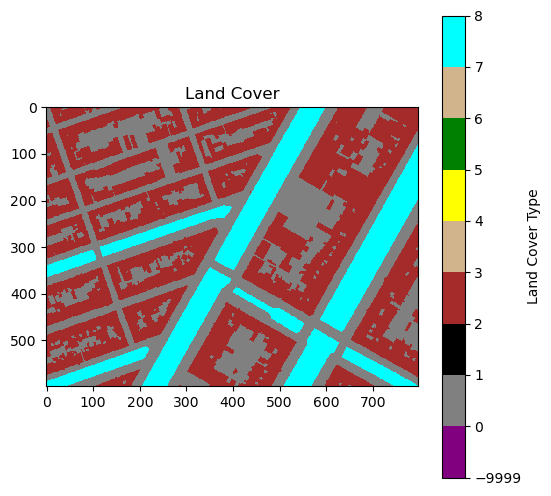

In [8]:
bbox = (120570,487570,120970,487870)
crs = "http://www.opengis.net/def/crs/EPSG/0/28992"
dataset_path = "D:/Geomatics/thesis/oldwallvsnewwallmethod/option2/final_dsm.tif"
buildings_path = "D:/Geomatics/thesis/oldwallvsnewwallmethod/option2/buildings.gpkg"
output = "D:/Geomatics/thesis/oldwallvsnewwallmethod/option2/landcover.tif"
landcover = LandCover(bbox, crs, dataset_path=dataset_path, buildings_path=buildings_path, layer="buildings")

In [46]:
solweig_folder = "D:/Geomatics/thesis/oldwallvsnewwallmethod/option2/solweig_pet"
building_mask = landcover.building_mask
water_mask = landcover.water_mask
print(building_mask.shape)

(598, 798)


In [54]:
from rasterio.features import geometry_mask, shapes
from shapely.geometry import shape,box
class TmrtOutput:
    def __init__(self, output_folder, building_mask=None, water_mask=None):
        self.output_folder = output_folder
        self.gdal_dataset = None

        self.valid_mask = None
        self.init_mask(building_mask, water_mask)

        self.tmrt_arrays_by_time = self.calc_arrays(output_folder)
        self.time_groups = self.group_by_time_of_day()
        self.averaged_tmrt = self.average_time_groups()

        self.pet_arrays_by_time = {}
        self.classified_pet_by_time = {}
        self.averaged_pet = {}
        self.averaged_class_pet = {}

    def init_mask(self, building_mask, water_mask):
        """
        Update the valid mask by combining the building and water masks.
        Pixels marked as buildings or water are invalid (set to False).
        """
        # Start with an all-True mask (valid everywhere)
        self.valid_mask = np.ones_like(building_mask, dtype=bool)

        # Apply the building mask (mark buildings as invalid)
        if building_mask is not None:
            self.valid_mask &= (building_mask != 0)

        # Apply the water mask (mark water areas as invalid)
        if water_mask is not None:
            self.valid_mask &= (water_mask != 0)


    def get_pet_raster_from_lookup(self, tmrt_raster, wind_speed, air_temp, rh, body_type, lookup_file,
                               tmrt_min=0, tmrt_max=65, tmrt_step=0.5, wind_speeds=None, rhs=None, temps=None):
        """
        Get the PET raster for a given Tmrt raster and environmental conditions.

        Parameters:
            tmrt_raster (np.ndarray): TMRT raster array.
            wind_speed (float): Wind speed in m/s.
            air_temp (float): Air temperature in °C.
            rh (float): Relative humidity in %.
            body_type (str): Body type for PET lookup ('standard_man', 'elderly_woman', 'young_child').
            lookup_file (str): Path to the HDF5 lookup file.
            tmrt_min (float): Minimum TMRT value (default 0°C).
            tmrt_max (float): Maximum TMRT value (default 65°C).
            tmrt_step (float): Step size for TMRT values (default 0.5°C).
            wind_speeds (list): List of wind speed values (default [0.1, 2.0, 6.0]).
            rhs (list): List of relative humidity values (default [100, 80, 60, 40, 20, 0]).
            temps (list): List of air temperature values (default [40, 39.5, 39.0, 38.5, .... 0.5, 0.0]).

        Returns:
            np.ndarray: PET raster corresponding to the given parameters.
        """
        if wind_speeds is None:
            wind_speeds = np.array([0.1, 2.0, 6.0])  # Default wind speed values if not provided
        if rhs is None:
            rhs = np.arange(100, -1, -10)  # Default relative humidity values if not provided
        if temps is None:
            temps = np.arange(40.0, -0.1, -0.5)  # Default air temperature values if not provided

        with h5py.File(lookup_file, "r") as f:
                pet_dataset = f[body_type]

                def find_nearest_index(array, value):
                    return np.abs(array - value).argmin()

                # Find the closest indices for the environmental conditions
                ws_idx = find_nearest_index(wind_speeds, wind_speed)
                rh_idx = find_nearest_index(rhs, rh)
                ta_idx = find_nearest_index(temps, air_temp)

                # Clip and map tmrt values to lookup indices based on configurable parameters
                tmrt_clipped = np.clip(tmrt_raster, tmrt_min, tmrt_max)

                tmrt_clipped_valid = tmrt_clipped[self.valid_mask]

                # Calculate the indices only for valid TMRT values
                tmrt_indices_valid = np.round((tmrt_clipped_valid - tmrt_min) / tmrt_step).astype(int)

                # Ensure that indices stay within bounds for valid TMRT values
                max_index = int((tmrt_max - tmrt_min) / tmrt_step)
                tmrt_indices_valid = np.clip(tmrt_indices_valid, 0, max_index)
                tmrt_indices_valid = max_index - tmrt_indices_valid

                # Create an array of the same shape as the original TMRT raster and fill it with -1
                tmrt_indices = np.full_like(tmrt_raster, -1, dtype=int)

                # Place the valid indices into the correct positions
                tmrt_indices[self.valid_mask] = tmrt_indices_valid

                # Fetch the PET raster based on these indices
                pet_raster = np.take(pet_dataset[ws_idx, rh_idx, :, ta_idx], tmrt_indices)

                # Handle NaN areas where tmrt was outside the valid range
                pet_raster[~self.valid_mask] = np.nan

                return pet_raster

    def calc_arrays(self, output_folder):
        tmrt_arrays_by_time = {}

        pattern = re.compile(r'^Tmrt_\d{4}_\d{3}_(\d{4})D\.tif$')

        for filename in os.listdir(output_folder):
            match = pattern.match(filename)
            if match:
                time_key = match.group(1)
                file_path = os.path.join(output_folder, filename)

                # Open file using gdal
                dataset = gdal.Open(file_path)
                if dataset is None:
                    print(f"Could not open {file_path}")
                    continue

                band = dataset.GetRasterBand(1)
                array = band.ReadAsArray()

                masked_array = np.where(self.valid_mask == 0, np.nan, array)

                tmrt_arrays_by_time[time_key] = masked_array

        return tmrt_arrays_by_time

    def get_time_group(self, time_str):
        time_val = int(time_str)
        if 600 <= time_val < 1200:
            return 'morning'
        elif 1200 <= time_val < 1800:
            return 'afternoon'
        elif 1800 <= time_val <= 2100:
            return 'evening'
        return None

    def group_by_time_of_day(self):
        grouped = {'morning': [], 'afternoon': [], 'evening': []}

        for time_str, array in self.tmrt_arrays_by_time.items():
            group = self.get_time_group(time_str)
            if group:
                grouped[group].append(array)

        return grouped

    def average_time_groups(self):
        avg_by_group = {}
        for group, arrays in self.time_groups.items():
            if arrays:
                stacked = np.stack(arrays)
                avg = np.mean(stacked, axis=0)
                avg_by_group[group] = avg
            else:
                avg_by_group[group] = None
        return avg_by_group

    def calculate_stats_and_bins(self, array, pixel_size=0.5, isTmrt=True):
        if isTmrt:
            bins = [-np.inf, 15, 20, 25, 30, 35, 40, 45, 50, np.inf]
        else:
            bins = [-np.inf, 4, 8, 13, 18, 23, 29, 35, 41, np.inf]

        stats = {
            'mean': np.nanmean(array),
            'median': np.nanmedian(array),
            'min': np.nanmin(array),
            'max': np.nanmax(array),
        }

        hist, bin_edges = np.histogram(array[self.valid_mask], bins=bins)
        pixel_area = pixel_size ** 2
        bin_areas = hist * pixel_area
        total_area = np.sum(bin_areas)
        bin_percentages = (bin_areas / total_area) * 100

        stats['bins'] = [
            {
                'range': (bin_edges[i], bin_edges[i + 1]),
                'area_m2': bin_areas[i],
                'percentage': bin_percentages[i]
            }
            for i in range(len(hist))
        ]

        return stats

    def classify_pet(self, pet_array):
        """
        Classify PET array into bins.
        Returns an integer array where each pixel has the class index (0 to len(bins)-2).
        Pixels with NaN PET will remain NaN.
        """
        bins = [-np.inf, 4, 8, 13, 18, 23, 29, 35, 41, np.inf]
        classified = np.digitize(pet_array, bins) - 1
        classified = classified.astype(float)
        classified[np.isnan(pet_array)] = np.nan

        return classified

    def calc_pet(self, Ta, RH, va, body_type="standard_man", lookup_file="pet_lookup.h5"):
        """
        Compute PET array for the 1300 TMRT time step using precomputed PET lookup.
        Inputs:
            Ta: Air temperature in °C (scalar)
            RH: Relative humidity in % (scalar)
            va: Wind speed in m/s (scalar)
            body_type: One of "standard_man", "elderly_woman", "young_child"
            lookup_file: Path to PET HDF5 lookup file
        """
        for time_key, Tmrt in self.tmrt_arrays_by_time.items():
            if Tmrt is None:
                print(f"Skipping {time_key}: Tmrt data is None")
                continue

            try:
                pet_array = self.get_pet_raster_from_lookup(Tmrt, va, Ta, RH, body_type, lookup_file)
                self.pet_arrays_by_time[time_key] = pet_array
                self.classified_pet_by_time[time_key] = self.classify_pet(pet_array)
            except Exception as e:
                print(f"Failed to compute PET for {time_key}: {e}")

        for time_key, Tmrt in self.averaged_tmrt.items():
            if Tmrt is None:
                print(f"Skipping {time_key}: Tmrt data is None")
                continue

            try:
                pet_array = self.get_pet_raster_from_lookup(Tmrt, va, Ta, RH, body_type, lookup_file)
                self.averaged_pet[time_key] = pet_array
                self.averaged_class_pet[time_key] = self.classify_pet(pet_array)
            except Exception as e:
                print(f"Failed to compute PET for {time_key}: {e}")


        # Tmrt = self.tmrt_arrays_by_time.get("1700")
        # if Tmrt is None:
        #     raise ValueError("1300 time step not found in Tmrt data.")
        #
        # # compute PET raster from old original code
        # Ta_array = (Ta if isinstance(Ta, np.ndarray) else np.full_like(Tmrt, Ta)).astype(np.float64)
        # RH_array = (RH if isinstance(RH, np.ndarray) else np.full_like(Tmrt, RH)).astype(np.float64)
        # va_array = (va if isinstance(va, np.ndarray) else np.full_like(Tmrt, va )).astype(np.float64)
        # Tmrt = Tmrt.astype(np.float64)
        # #
        # pet_model = Pet()
        # # pet_array = calculate_PET_index(Ta_array, RH_array, Tmrt, va_array, pet_model)
        # pet_array = calculate_PET_grid(Ta_array, RH_array, Tmrt, va_array, pet_model)
        # self.pet_arrays_by_time["1700"] = pet_array
        #
        # # # Compute PET raster from lookup
        # pet_array = self.get_pet_raster_from_lookup(Tmrt, va, Ta, RH, body_type, lookup_file)
        # self.pet_arrays_by_time["1300"] = pet_array
        #
        #
        # self.classified_pet_by_time["1700"] = self.classify_pet(pet_array)



In [55]:
# Define your folder path

tmrt = TmrtOutput(solweig_folder, building_mask=building_mask, water_mask=water_mask)

In [49]:
pet_model = Pet()

In [57]:
tmrt.calc_pet(20, 90, 0.1)

In [37]:
import matplotlib.pyplot as plt
def plot_raster(array, title="DSM original"):
    plt.figure(figsize=(10, 8), facecolor="white")
    ax = plt.gca()
    ax.set_facecolor("white")
    plt.imshow(array, cmap="viridis", origin="upper", vmin=0, vmax=30)
    plt.colorbar(label="Elevation (m)")
    plt.title(title)
    plt.show()

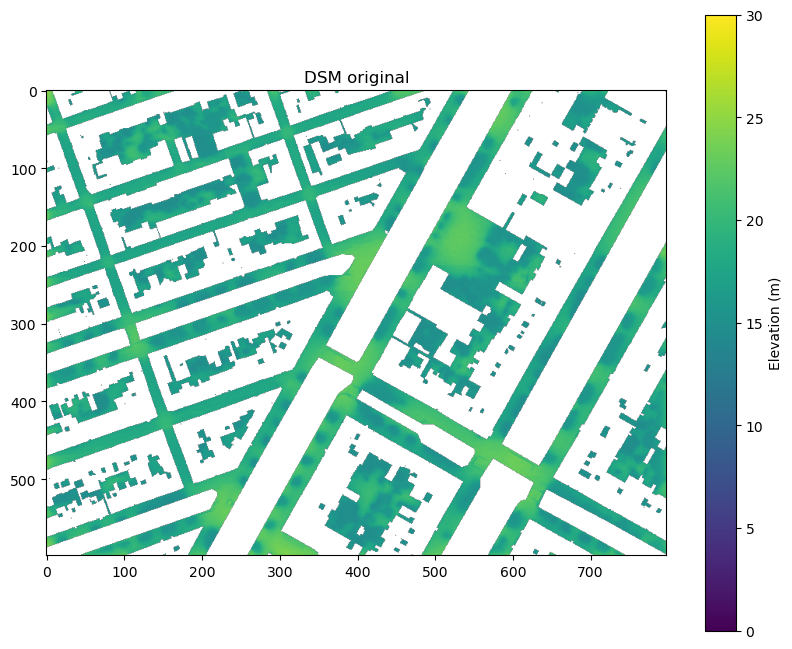

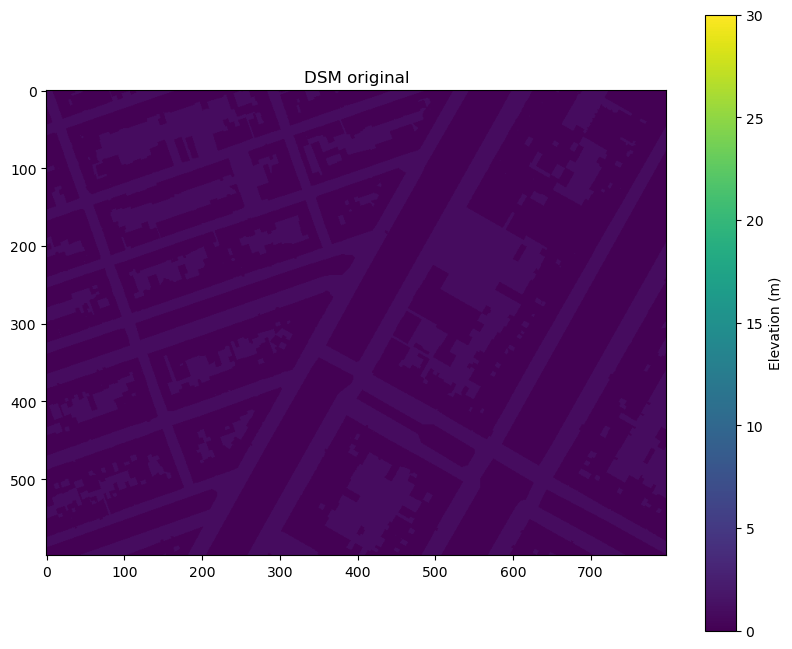

In [58]:
plot_raster(tmrt.tmrt_arrays_by_time["1700"])
plot_raster(tmrt.valid_mask)

In [23]:
gdal_dataset = gdal.Open('D:/Geomatics/thesis/oldwallvsnewwallmethod/option2/final_dsm.tif')

In [60]:
from util.misc import saveraster
saveraster(gdal_dataset, "output/thesis_pet_new_1300.tiff", tmrt.pet_arrays_by_time["1300"])
saveraster(gdal_dataset, "output/class_thesis_pet_new_1300.tiff", tmrt.classified_pet_by_time["1300"])

In [ ]:
print(tmrt.tmrt_arrays_by_time["1300"].shape)

In [21]:
for i in tmrt.tmrt_arrays_by_time:
    print(i)

0400
0500
0600
0700
0800
0900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


In [22]:
tmrt.calculate_stats_and_bins(tmrt.averaged_tmrt['morning'])

{'mean': 23.590565,
 'median': 22.003353,
 'min': 16.022554,
 'max': 35.385513,
 'bins': [{'range': (-inf, 15.0), 'area_m2': 0.0, 'percentage': 0.0},
  {'range': (15.0, 20.0), 'area_m2': 20888.5, 'percentage': 41.83892160397388},
  {'range': (20.0, 25.0),
   'area_m2': 9484.25,
   'percentage': 18.996614990185474},
  {'range': (25.0, 30.0),
   'area_m2': 8628.75,
   'percentage': 17.283078956856144},
  {'range': (30.0, 35.0),
   'area_m2': 10924.25,
   'percentage': 21.880883707887673},
  {'range': (35.0, 40.0),
   'area_m2': 0.25,
   'percentage': 0.0005007410968232985},
  {'range': (40.0, 45.0), 'area_m2': 0.0, 'percentage': 0.0},
  {'range': (45.0, 50.0), 'area_m2': 0.0, 'percentage': 0.0},
  {'range': (50.0, inf), 'area_m2': 0.0, 'percentage': 0.0}]}

In [23]:
buildings_gdf = gpd.read_file(buildings_path, layer="lod13")
buildings = [{"geometry": mapping(geom)} for geom in buildings_gdf.geometry]

In [24]:
gdal_tmrt = gdal.Open(tmrt_path)
mrt_raster = gdal_tmrt.ReadAsArray()

In [25]:
# Get raster georeferencing info
transform = Affine.from_gdal(*gdal_tmrt.GetGeoTransform())
pixel_size_x = 0.5
pixel_size_y = 0.5
raster_shape = mrt_raster.shape

# Rasterize buildings to mask
building_shapes = [mapping(geom) for geom in buildings_gdf.geometry]
mask = features.rasterize(
    ((geom, 1) for geom in building_shapes),
    out_shape=raster_shape,
    transform=transform,
    fill=0,
    dtype=np.uint8
)

# Apply mask (set building areas to nan)
masked_raster = np.where(mask == 1, np.nan, mrt_raster)

# Calculate stats ignoring nan
mean_val = np.nanmean(masked_raster)
median_val = np.nanmedian(masked_raster)
min_val = np.nanmin(masked_raster)
max_val = np.nanmax(masked_raster)

# Bin data
bins = [-np.inf, 15, 20, 25, 30, 35, 40, 45, 50, np.inf]
hist, bin_edges = np.histogram(masked_raster[~np.isnan(masked_raster)], bins=bins)

# Calculate area of each bin (assuming square pixels)
pixel_area = pixel_size_x * pixel_size_y  # in map units, e.g., m²
bin_areas = hist * pixel_area

# Print results
print("Temperature Statistics (excluding buildings):")
print(f"Mean: {mean_val:.2f}, Median: {median_val:.2f}, Min: {min_val:.2f}, Max: {max_val:.2f}")

print("\nTemperature Bins (°C) and Area (m²):")
for i in range(len(hist)):
    print(f"{bin_edges[i]}–{bin_edges[i+1]} °C: {bin_areas[i]:.2f} m²")

Temperature Statistics (excluding buildings):
Mean: 30.44, Median: 35.33, Min: 18.41, Max: 44.85

Temperature Bins (°C) and Area (m²):
-inf–15.0 °C: 0.00 m²
15.0–20.0 °C: 1330.50 m²
20.0–25.0 °C: 20588.00 m²
25.0–30.0 °C: 1588.00 m²
30.0–35.0 °C: 816.75 m²
35.0–40.0 °C: 23823.50 m²
40.0–45.0 °C: 1779.25 m²
45.0–50.0 °C: 0.00 m²
50.0–inf °C: 0.00 m²


In [26]:
import matplotlib.pyplot as plt
def plot_raster(array, title="DSM original"):
        plt.figure(figsize=(10, 8), facecolor="white")
        ax = plt.gca()
        ax.set_facecolor("white")
        plt.imshow(array, cmap="viridis", origin="upper")
        plt.colorbar(label="Elevation (m)")
        plt.title(title)
        plt.show()

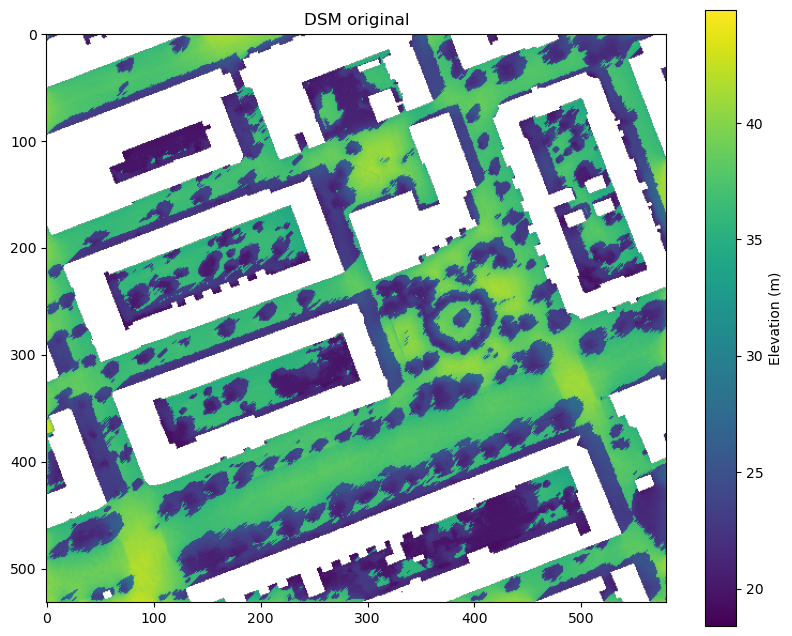

In [27]:
plot_raster(masked_raster)